# A guide to produce analysis-ready data

https://github.com/ikotarid/Sentinel-1-preprocessing/blob/main/sentinel1.ipynb

## 1. Load Python modules

In [2]:
# can replace these imports using requirements. txt and the following command
#%pip install -r requirements.txt
import sys
sys.path.append(r"<path>")

# MODULE                                # DESCRIPTION
import matplotlib.colors as colors      # create visualizations
import matplotlib.image as mpimg        # create visualizations
import matplotlib.pyplot as plt         # create visualizations
from termcolor import colored           # prints colored text
from zipfile import ZipFile             # zip file manipulation
from os.path import join                # data access in file manager  
from glob import iglob                  # data access in file manager
import pandas as pd                     # data analysis and manipulation
import numpy as np                      # scientific computing
import subprocess                       # external calls to system
import esa_snappy                           # SNAP python interface
import jpy                              # Python-Java bridge
from esa_snappy import PixelPos

# Change module setting
pd.options.display.max_colwidth = 80    # Longer text in pd.df

## 2. Sentinel-1 Preprocessing: snappy
#### User-defined function

In [3]:
def output_view(product, band, min_value_VV, max_value_VV, min_value_VH, max_value_VH):
    '''
    Creates visualization of processed Sentinel-1 SAR data
    
    Keyword arguments:
    product       -- snappy GPF product --> input Sentinel-1 product 
    band          -- List --> product's band to be visualized
    min_value_VV  -- int --> min value for color strech in VV band
    max_value_VV  -- int --> max value for color strech in VV band
    min_value_VH  -- int --> max value for color strech in VH band
    max_value_VV  -- int --> max value for color strech in VH band
    '''
    band_data_list = []
    
    for i in band:
        product_band = product.getBand(i)
        w = product_band.getRasterWidth()
        h = product_band.getRasterHeight()
        band_data = np.zeros(w * h, np.float32)
        product_band.readPixels(0, 0, w, h, band_data)
        band_data.shape = h, w
        band_data_list.append(band_data)
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,16))
    ax1.imshow(band_data_list[0], cmap='gray', vmin=min_value_VV , vmax=max_value_VV)
    ax1.set_title(band[0])
    ax2.imshow(band_data_list[1], cmap='gray', vmin=min_value_VH , vmax=max_value_VH)
    ax2.set_title(band[1])
    
    for ax in fig.get_axes():
        ax.label_outer()


The easiest way to know which operators are available in snappy is to call gpt -h from command line, which will output the list. If you want to access the documentation of a specific operator, use gpt -h *Operator*

In [4]:
# Call gpt -h from command line 
# print(subprocess.Popen(['gpt','-h', 'Subset'], stdout=subprocess.PIPE, universal_newlines=True).communicate()[0])


<center><img src=Processing_S_1_graph.png width="1400"/></center>


## 3.1 Read product

We start the analysis by setting the folder where the files we want to processed are located. Next, one of the files wil be used as input for this exercise and will be imported with `snappy`. In addition, a quicklook availalbe in the origianl data folder is displayed. 

data\S1A_IW_GRDH_1SDV_20250401T232816_20250401T232841_058570_073FA8_1A26.SAFE.zip
bottom left: (24.70653891369735, -81.8378841159868), Top right: (26.63335452928809, -79.63403342237105)


Name  \
0  S1A_IW_GRDH_1SDV_20250401T232816_20250401T232841_058570_073FA8_1A26   

  Sensing Mode     Product Type Polarization  Height  Width  \
0         1SDV  20250401T232816         1SDV   16748  25654   

                                            Available Bands  
0  [Amplitude_VH, Intensity_VH, Amplitude_VV, Intensity_VV]

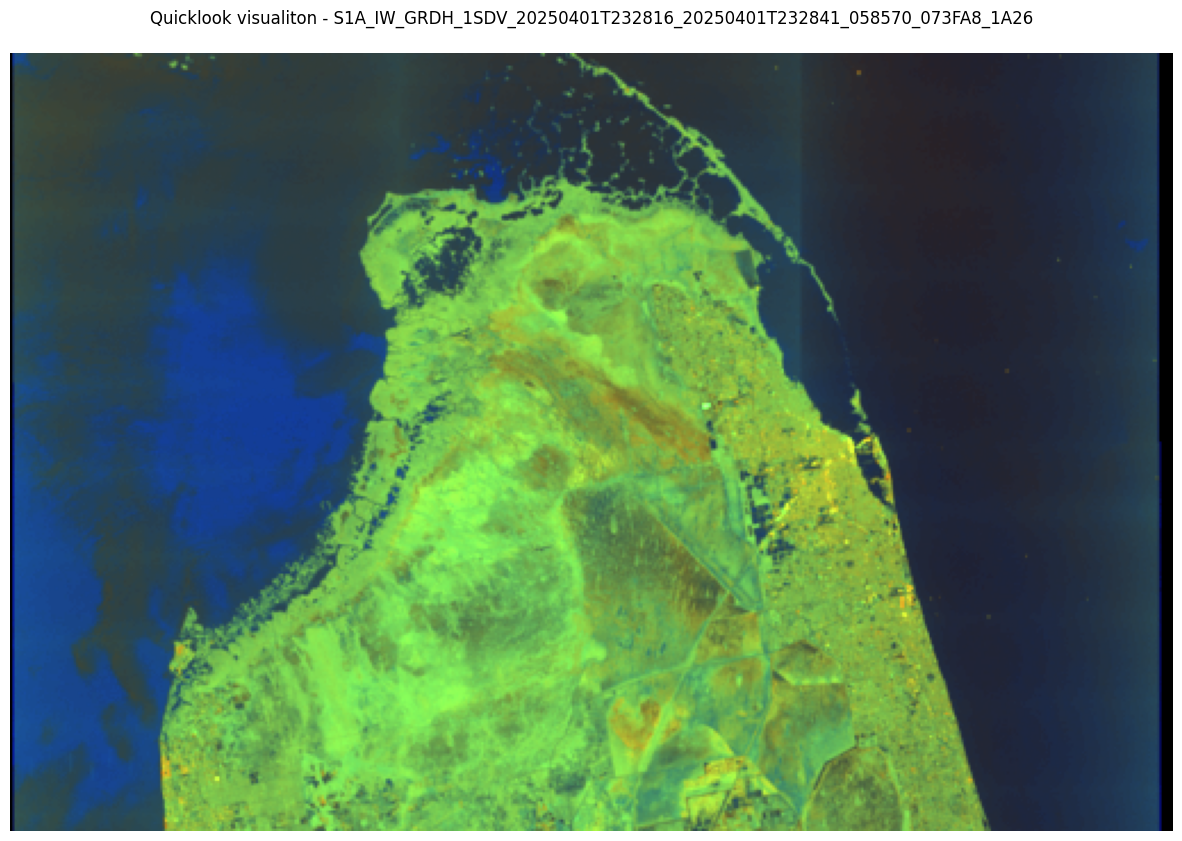

In [5]:
# Set target folder and extract metadata
product_path = "data"
input_S1_files = sorted(list(iglob(join(product_path, '**', '*S1*.zip'), recursive=True)))

name, sensing_mode, product_type, polarization, height, width, band_names = ([] for i in range(7))

bottom_left_coords = []
top_right_coords = []
for i in input_S1_files:
    print(i)
    sensing_mode.append(i.split("_")[3])
    product_type.append(i.split("_")[4])
    polarization.append(i.split("_")[-6])
    # Read with snappy
    s1_read = esa_snappy.ProductIO.readProduct(i)
    name.append(s1_read.getName())
    height_val = s1_read.getSceneRasterHeight()
    width_val = s1_read.getSceneRasterWidth()
    height.append(s1_read.getSceneRasterHeight())
    width.append(s1_read.getSceneRasterWidth())
    band_names.append(s1_read.getBandNames())
    geo_coding = s1_read.getSceneGeoCoding()

    # get bottom-left and top-right geo coordinates for SMAP data retrieval
    bottom_left = geo_coding.getGeoPos(PixelPos(0, 0), None)
    top_right = geo_coding.getGeoPos(PixelPos(width_val - 1, height_val - 1), None)

    bottom_left_coords.append((bottom_left.getLat(), bottom_left.getLon()))
    top_right_coords.append((top_right.getLat(), top_right.getLon()))

    print(f"bottom left: {bottom_left_coords[-1]}, Top right: {top_right_coords[-1]}")

np.save('coordinates.npy', [bottom_left_coords, top_right_coords])

df_s1_read = pd.DataFrame({'Name': name, 'Sensing Mode': sensing_mode,'Product Type': product_type, 'Polarization': polarization ,'Height': height, 'Width': width, 'Available Bands': band_names})
display(df_s1_read)

# Display quicklook - First image
with ZipFile(input_S1_files[0], 'r') as qck_look:
    qck_look = qck_look.open(name[0] + '.SAFE/preview/quick-look.png')
    img = mpimg.imread(qck_look, format='PNG')
    plt.figure(figsize = (15,15))
    plt.title('Quicklook visualiton - '+ name[0] + '\n')
    plt.axis('off')
    plt.imshow(img)

## 3.2 Subset

Once the product is read, we continue our processing chain by creating a subset of the Sentinel-1 product. It is recommened to run this step to reduce processing time. To define the Area Of Interest (AOI), we are defining pixel coordinates, taking as reference the upper right corner of the raster

['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']


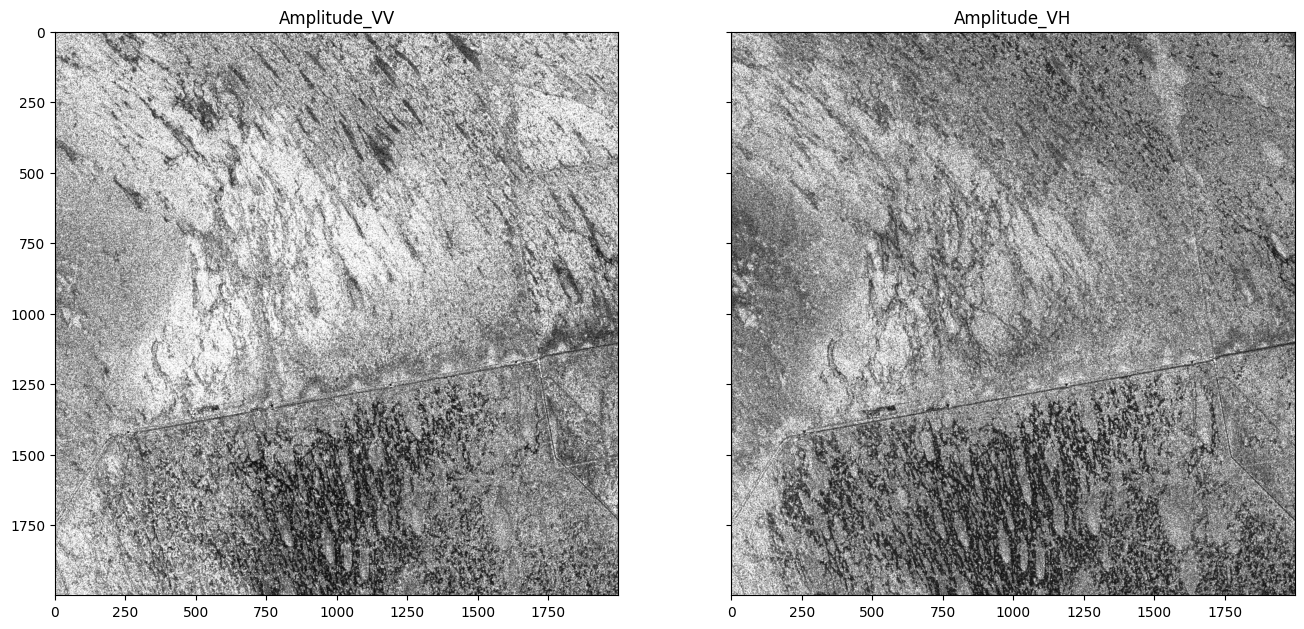

In [6]:
# upper right corner
x, y, width, height = 12000, 8000, 2000, 2000

# Subset Operator - snappy
parameters = esa_snappy.HashMap() 
parameters.put('copyMetadata', True)
parameters.put('region', "%s,%s,%s,%s" % (x, y, width, height))
subset = esa_snappy.GPF.createProduct('Subset', parameters, s1_read)
print(list(subset.getBandNames()))

# Plot subset (follow VV - VH order)
output_bands = ['Amplitude_VV', 'Amplitude_VH']
output_view(subset, output_bands, 41, 286, 20, 160)

In [7]:
outpath_name = '1_S1A_IW_GRDH_1SDV_20250401_snappy_subset'
esa_snappy.ProductIO.writeProduct(subset, outpath_name, 'GeoTIFF')

## 3.3 Apply Orbit File

The orbit state vectors provided in the metadata of a SAR product are generally not accurate and can be refined with the precise orbit files which are available days-to-weeks after the generation of the product. The orbit file provides accurate satellite position and velocity information. Based on this information, the orbit state vectors in the abstract metadata of the product are updated.

In [8]:
# Apply Orbit File Operator - snappy
parameters = esa_snappy.HashMap()
parameters.put('Apply-Orbit-File', True)
apply_orbit = esa_snappy.GPF.createProduct('Apply-Orbit-File', parameters, subset)
print(colored('Orbit updated succesfully', 'green'))

Orbit updated succesfully


## 3.4 Thermal Noise Removal

Thermal noise in SAR imagery is the background energy that is generated by the receiver itself. It skews the radar reflectivity towards higher values and hampers the precision of radar reflectivity estimates. Level-1 products provide a noise LUT for each measurement dataset, provided in linear power, which can be used to remove the noise from the product.

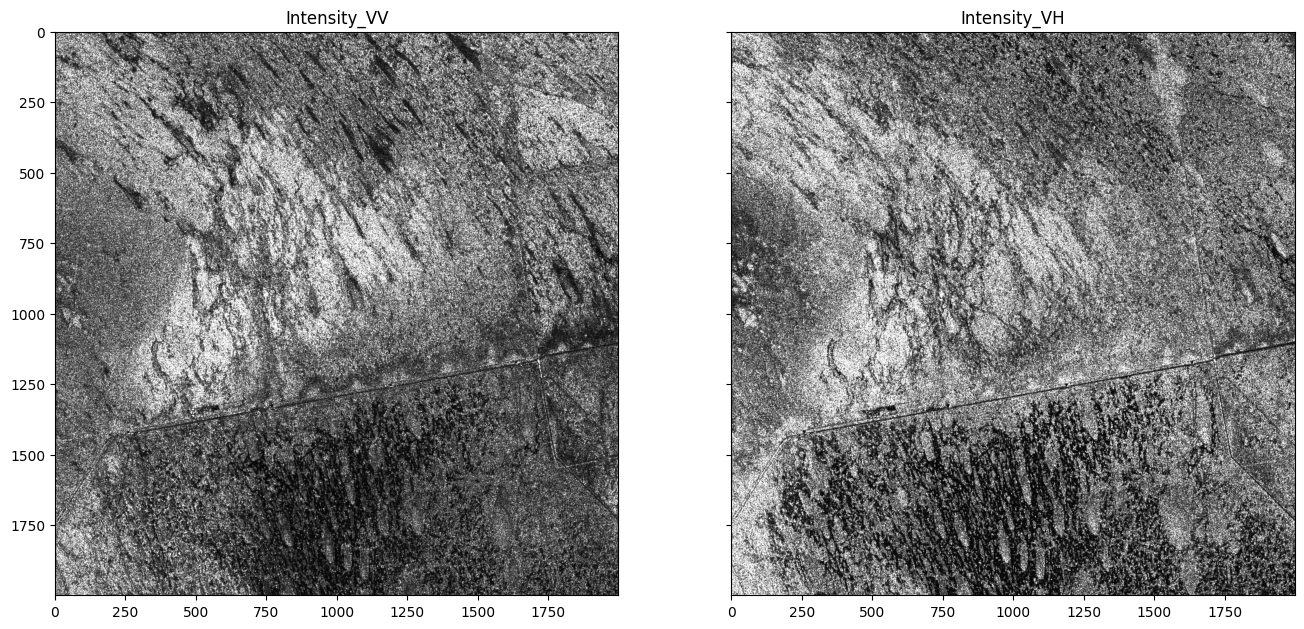

In [9]:
# Thermal Noise Removal Operator - snappy
parameters = esa_snappy.HashMap()
parameters.put('removeThermalNoise', True)
thermal_noise = esa_snappy.GPF.createProduct('ThermalNoiseRemoval', parameters, apply_orbit)

# Plot Thermal Noise Removal (follow VV - VH order)
output_bands = ['Intensity_VV', 'Intensity_VH']
output_view(thermal_noise, output_bands, 0.02, 99376.52, 0.27, 18471.83)

In [10]:
outpath_name = '2_S1A_IW_GRDH_1SDV_20250401_snappy_thermal_noise'
esa_snappy.ProductIO.writeProduct(thermal_noise, outpath_name, 'GeoTIFF')

## 3.5 Radiometric Calibration

The objective of SAR calibration is to provide imagery in which the pixel values can be directly related to the radar backscatter of the scene. Though uncalibrated SAR imagery is sufficient for qualitative use, calibrated SAR images are essential to quantitative use of SAR data. Typical SAR data processing, which produces Level-1 images, does not include radiometric corrections and significant radiometric bias remains. The radiometric correction is necessary for the pixel values to truly represent the radar backscatter of the reflecting surface and therefore for comparison of SAR images acquired with different sensors, or acquired from the same sensor but at different times, in different modes, or processed by different processors.

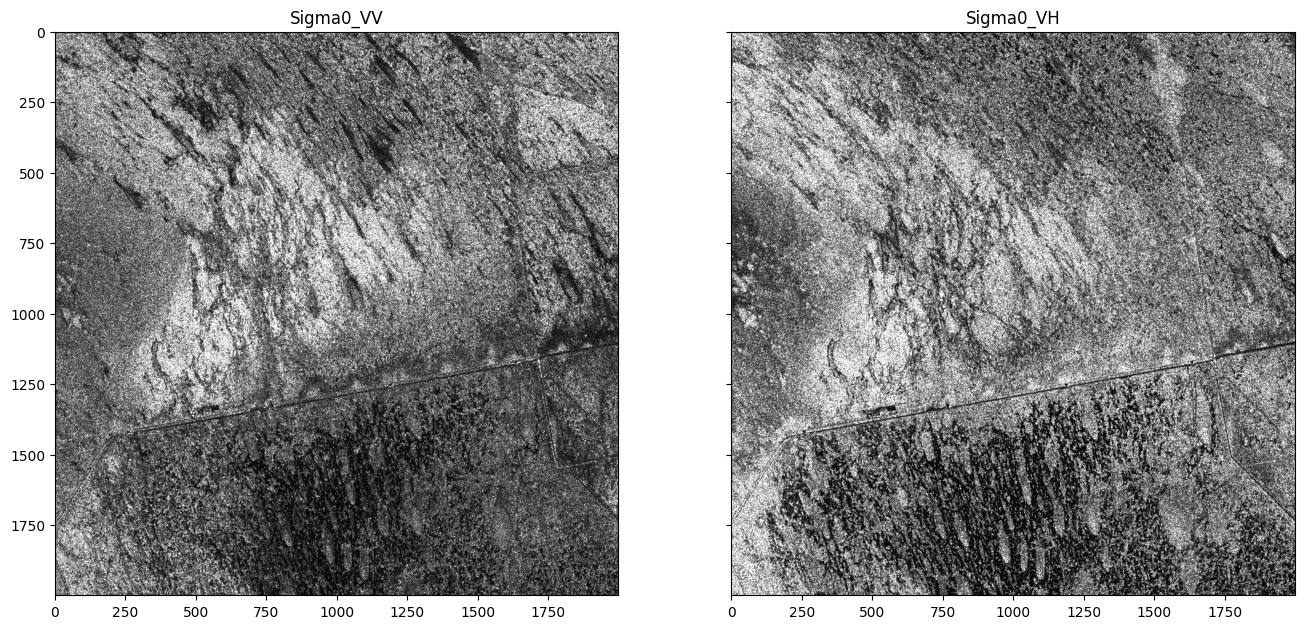

In [11]:
# Calibration Operator - snappy
parameters = esa_snappy.HashMap()
parameters.put('outputSigmaBand', True)
parameters.put('sourceBands', 'Intensity_VH,Intensity_VV')
parameters.put('selectedPolarisations', 'VH,VV')
parameters.put('outputImageScaleInDb', False)
calibrated = esa_snappy.GPF.createProduct("Calibration", parameters, thermal_noise)

# Plot Calibration (follor VV - VH order)
output_bands = ['Sigma0_VV', 'Sigma0_VH'] 
output_view(calibrated, output_bands, 0.00, 0.28, 0.00, 0.05)

## 3.6 Speckle Filtering

SAR images have inherent salt and pepper like texturing called speckles which degrade the quality of the image and make interpretation of features more difficult. Speckles are caused by random constructive and destructive interference of the de-phased but coherent return waves scattered by the elementary scatters within each resolution cell. Speckle noise reduction can be applied either by spatial filtering or multilook processing.

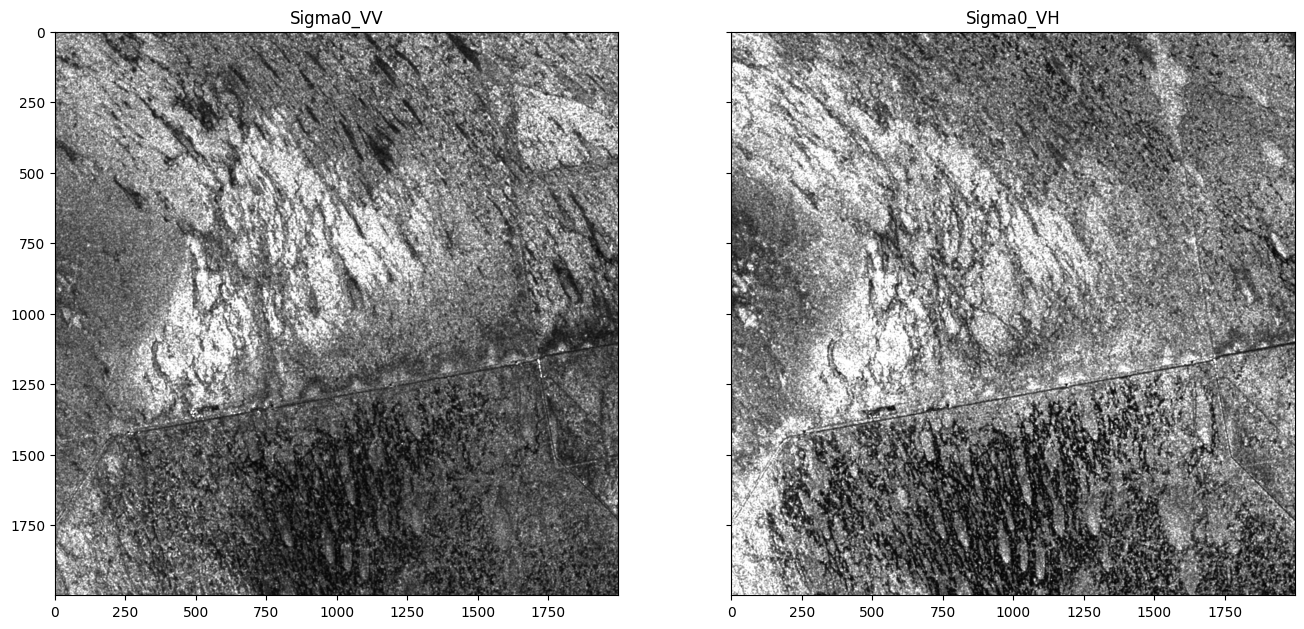

In [12]:
# Speckle Filtering Operator - snappy
parameters = esa_snappy.HashMap()
parameters.put('filter', 'Lee')
parameters.put('filterSizeX', jpy.get_type('java.lang.Integer')(5))
parameters.put('filterSizeY', jpy.get_type('java.lang.Integer')(5))
speckle = esa_snappy.GPF.createProduct('Speckle-Filter', parameters, calibrated)

# Plot speckle filter (follow VV - VH order)
output_bands = ['Sigma0_VV', 'Sigma0_VH']
output_view(speckle, output_bands, 0.00, 0.28, 0.00, 0.05)

## 3.7 Terrain Correction

Due to topographical variations of a scene and the tilt of the satellite sensor, distances can be distorted in the SAR images. Image data not directly at the sensor’s Nadir location will have some distortion. Terrain corrections are intended to compensate for these distortions so that the geometric representation of the image will be as close as possible to the real world.

In [13]:
#Get proj information from .xml file (graph) that includes Range Doppler Terrain Correction with UTM/Automtic parameter
proj = '''PROJCS["UTM Zone 35 / World Geodetic System 1984", 
  GEOGCS["World Geodetic System 1984", 
    DATUM["World Geodetic System 1984", 
      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], 
      AUTHORITY["EPSG","6326"]], 
    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], 
    UNIT["degree", 0.017453292519943295], 
    AXIS["Geodetic longitude", EAST], 
    AXIS["Geodetic latitude", NORTH]], 
  PROJECTION["Transverse_Mercator"], 
  PARAMETER["central_meridian", 27.0], 
  PARAMETER["latitude_of_origin", 0.0], 
  PARAMETER["scale_factor", 0.9996], 
  PARAMETER["false_easting", 500000.0], 
  PARAMETER["false_northing", 0.0], 
  UNIT["m", 1.0], 
  AXIS["Easting", EAST], 
  AXIS["Northing", NORTH]]''' 

# Terrain-Correction Operator - snappy
parameters = esa_snappy.HashMap()
parameters.put('demName', 'SRTM 3Sec')
parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('pixelSpacingInMeter', 10.0)
# ensures terrain flattening in the same operation - terrain flattening is equivalent to radiometric terrain correction
# https://www.mdpi.com/2072-4292/15/7/1932#:~:text=A%20terrain%2Dflattened%20or%20Radiometrically,for%20terrain%2Drelated%20radiometric%20effects.
parameters.put('applyRadiometricNormalization', True)
# parameters.put('mapProjection', proj)
parameters.put('nodataValueAtSea', False) # do not mask areas without elevation (WATER AREAS!)
parameters.put('saveSelectedSourceBand', True)
terrain_correction = esa_snappy.GPF.createProduct('Terrain-Correction', parameters, speckle)

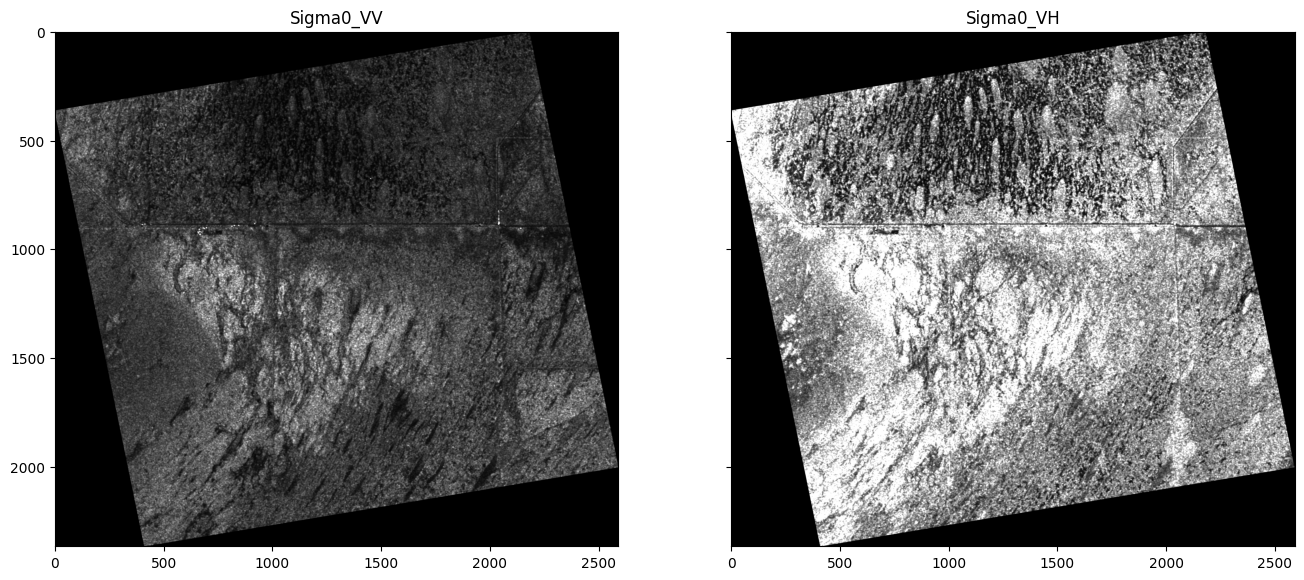

In [14]:
# Plot terrain correction (follow VV - VH order)
output_bands = ['Sigma0_VV', 'Sigma0_VH']
output_view(terrain_correction, output_bands, 0.00, 0.49, 0.00, 0.04)

## 3.8 Write

Once we have completed all preprocessing steps we can write our SAR product to file. In this occasion we will chooose the GeoTIFF format.

In [15]:
# Set output path and name
outpath_name = 'S1A_IW_GRDH_1SDV_20250401_snappy'

# Write Operator - snappy
esa_snappy.ProductIO.writeProduct(terrain_correction, outpath_name, 'GeoTIFF')
print(colored('Product succesfully saved in:', 'green'), outpath_name)

Product succesfully saved in: S1A_IW_GRDH_1SDV_20250401_snappy


In [16]:
# Set output path and name
outpath_name = 'S1A_IW_GRDH_1SDV_20250401_snappy_speckle'

# Write Operator - snappy
esa_snappy.ProductIO.writeProduct(speckle, outpath_name, 'GeoTIFF')
print(colored('Product succesfully saved in:', 'green'), outpath_name)

Product succesfully saved in: S1A_IW_GRDH_1SDV_20250401_snappy_speckle


In [17]:
outpath_name = 'S1A_IW_GRDH_1SDV_20250401_snappy_calibrated'
esa_snappy.ProductIO.writeProduct(calibrated, outpath_name, 'GeoTIFF')

## Soil Moisture Preparation
Soil moisture is taken from backscatter values, which terrain correction produces to be either Sigma0_VV or Sigma0_VH. We choose VV because it tends to be more sensitive and thus preferred for soil moisture (https://forum.step.esa.int/t/sentinel-1-vh-vs-vv-polarizations/20811). We also need the geographic coordinates for each soil moisture point so that we can plot our soil moisture estimates for our area of interest.

In [18]:
# inspired by output view function
vv_band = terrain_correction.getBand('Sigma0_VV')
w = vv_band.getRasterWidth()
h = vv_band.getRasterHeight()
vv_band_data = np.zeros(w * h, np.float32)
vv_band.readPixels(0, 0, w, h, vv_band_data)
vv_band_data.shape = h, w

def linear_to_db(sar_linear):
    # mask out zeros and negatives to avoid -inf or NaNs
    sar_linear = np.where(sar_linear > 0, sar_linear, np.nan)
    return 10 * np.log10(sar_linear)

s1_backscatter_db = linear_to_db(vv_band_data)  

# prepare output
s1_longs = np.zeros((height, width), dtype=np.float32)
s1_lats = np.zeros((height, width), dtype=np.float32)

geo_coding = terrain_correction.getSceneGeoCoding()
# get coordinates
for y in range(height):
    for x in range(width):
        pixel_pos = PixelPos(x, y)
        geo_pos = geo_coding.getGeoPos(pixel_pos, None)
        
        s1_longs[y, x] = geo_pos.lon
        s1_lats[y, x] = geo_pos.lat


# flatten arrays for interpolation (accounting for difference between sentinel1 vs SMAP L3)
s1_longs = s1_longs.flatten()
s1_lats = s1_lats.flatten()
s1_backscatter_db = s1_backscatter_db.flatten()

# be able to access in soil moisture estimation notebook
np.save('s1_longs.npy', s1_longs)
np.save('s1_lats.npy', s1_lats)
np.save('s1_backscatter_db.npy', s1_backscatter_db)
